In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


https://www.sfu.ca/~ssurjano/egg.html



The Eggholder function is a difficult function to optimize, because of the large number of local minima. 

Input Domain: xi ∈ [-512, 512], for all i = 1, 2. 

In [69]:

class EggHolderLikelihood:
    '''
    This class represents the likelihood function based on the Egg Holder function
    
    '''
    def __init__(self):
        '''
        Initialize the class with bounds for the x and y variables
        '''
        # Bounds for x and y variables
        self.bounds = [(-512, 512), (-512, 512)]  # The function is usually evaluated on the square xi ∈ [-512, 512], for all i = 1, 2

    def eggholder(self, x, y):
        '''
        Evaluates the Egg Holder function at the given (x, y) coordinates

        Arguments
        x [float]: The x coordinate
        y [float]: The y coordinate

        Returns
        fx[float]: The value of the Egg Holder function at (x, y)
        '''
        fx = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(abs(x - (y + 47))))
        return fx
    
    def evaluate(self, params):
        '''
        
        '''
        x, y = params
        return self.eggholder(x, y)


    def log_likelihood(self, params, z_observed):
        '''
        Calculates the log likelihood value based on the observed and predicted values

        Arguments
        params [tuple]: The parameter values (x, y) for the Eggholder function
        z_observed [array]: The observed values of the Eggholder function

        Returns
        log_likelihood [float]: The log-likelihood value
        '''
        x, y = params
        z_predicted = self.evaluate(params)
        log_likelihood = -0.5 * np.sum((z_observed - z_predicted) ** 2)
        return log_likelihood

    def log_prior(self, params):
        '''
        Calculates the log prior probability based on the parameter values

        Arguments
        params [tuple]: The parameter values (x, y) for the Eggholder function

        Returns
        log_prior [float]: The log-prior probability
        '''
        x, y = params
        if self.bounds[0][0] <= x <= self.bounds[0][1] and self.bounds[1][0] <= y <= self.bounds[1][1]:
            return 0.0
        else:
            return -np.inf

    def log_posterior(self, params, z_observed):
        '''
        Calculates the log posterior probability based on the parameter values and observed values

        Arguments
        params [tuple]: The parameter values (x, y) for the Eggholder function
        z_observed [array-like]: The observed values of the Eggholder function

        Returns:
        log_posterior [float]: The log-posterior probability
        '''
        log_prior = self.log_prior(params)
        if np.isinf(log_prior):
            return log_prior
        log_likelihood = self.log_likelihood(params, z_observed)
        return log_prior + log_likelihood
    
    def add_poisson_fluctuation(self, z):
        '''
        Adds Poisson fluctuation to the Eggolder function values

        Arguments:
        z [array]: The values of the Eggholder function

        Returns:
        z_fluctuated [array]: The fluctuated values of the Eggholder function
        '''
        offset = np.abs(np.min(z))
        z_offset = z + offset
        z_fluctuated = np.random.poisson(z_offset)
        z_fluctuated -= np.array(offset, dtype=z_fluctuated.dtype)
        return z_fluctuated

    def plot_scatter(self):
        '''
        
        '''
        # Create an array of x and y values
        x = np.linspace(-512, 512, 400)
        y = np.linspace(-512, 512, 400)

        # Create a grid of x and y values
        x, y = np.meshgrid(x, y)

        # Calculate the z values
        z = self.eggholder(x, y)

        # Add Poisson fluctuation to z values
        z_fluctuated = self.add_poisson_fluctuation(z)

        # Create the plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x, y, z_fluctuated, cmap='viridis', edgecolor='k')
        ax.set_title('3D Plot of Eggholder Function with Poisson Fluctuation')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('f(X, Y)')
        plt.savefig('3D Eggholder Function')
        plt.show()

    def find_peaks_troughs(self, num_points=100):
        x = np.linspace(-512, 512, num_points)
        y = np.linspace(-512, 512, num_points)
        X, Y = np.meshgrid(x, y)
        z = self.eggholder(X, Y)

        peaks = 0
        troughs = 0

        for i in range(1, num_points - 1):
            for j in range(1, num_points - 1):
                if (
                    z[i, j] > z[i-1, j] and z[i, j] > z[i+1, j] and
                    z[i, j] > z[i, j-1] and z[i, j] > z[i, j+1]
                ):
                    peaks += 1
                elif (
                    z[i, j] < z[i-1, j] and z[i, j] < z[i+1, j] and
                    z[i, j] < z[i, j-1] and z[i, j] < z[i, j+1]
                ):
                    troughs += 1

        return peaks, troughs
    
    def find_local_minimum(self, start_point, learning_rate=0.01, num_iterations=100):
        '''
        
        '''
        current_point = np.array(start_point)
        history = [current_point]

        for _ in range(num_iterations):
            x, y = current_point
            grad_x = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(abs(x - (y + 47)))) * (1/2) * (1/np.sqrt(abs(x - (y + 47)))) * np.sign(x - (y + 47))
            grad_y = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) - (1/2) * np.sin(np.sqrt(abs(x - (y + 47)))) * (1/np.sqrt(abs(x/2 + (y + 47)))) * np.sign(y + 47) - x * np.sin(np.sqrt(abs(x - (y + 47))))
            gradient = np.array([grad_x, grad_y])
            current_point = current_point - learning_rate * gradient
            history.append(current_point)

        return current_point, history
    
    def find_all_local_minima(self, num_points, range_x, range_y, learning_rate=0.01, num_iterations=100):
        '''
        
        '''
        local_minima = []

        # Generate random start points within the specified range
        start_points = np.random.uniform(low=[range_x[0], range_y[0]], high=[range_x[1], range_y[1]], size=(num_points, 2))

        for start_point in start_points:
            current_point = np.array(start_point)
            history = [current_point]

            for _ in range(num_iterations):
                x, y = current_point
                grad_x = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(abs(x - (y + 47)))) * (1/2) * (1/np.sqrt(abs(x - (y + 47)))) * np.sign(x - (y + 47))
                grad_y = -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) - (1/2) * np.sin(np.sqrt(abs(x - (y + 47)))) * (1/np.sqrt(abs(x/2 + (y + 47)))) * np.sign(y + 47) - x * np.sin(np.sqrt(abs(x - (y + 47))))
                gradient = np.array([grad_x, grad_y])
                current_point = current_point - learning_rate * gradient
                history.append(current_point)

            local_minima.append(current_point)

        return local_minima

    




In [70]:
# Generate random observed z values
np.random.seed(42)  # Set random seed for reproducibility
z_observed = np.random.uniform(-100, 100, size=(10, 10))

# Instantiate the EggHolderLikelihood class
likelihood = EggHolderLikelihood()

# Choose parameter values for testing
params = (100, -200)  # Example parameter values

# Calculate the likelihood
likelihood_value = likelihood.evaluate(params)
print("Likelihood:", likelihood_value)

# Calculate the log-likelihood
log_likelihood_value = likelihood.log_likelihood(params, z_observed)
print("Log-Likelihood:", log_likelihood_value)

# Calculate the prior
prior_value = likelihood.log_prior(params)
print("Prior:", prior_value)

# Calculate the posterior
posterior_value = likelihood.log_posterior(params, z_observed)
print("Posterior:", posterior_value)


Likelihood: -81.68626748365273
Log-Likelihood: -461924.11578922824
Prior: 0.0
Posterior: -461924.11578922824


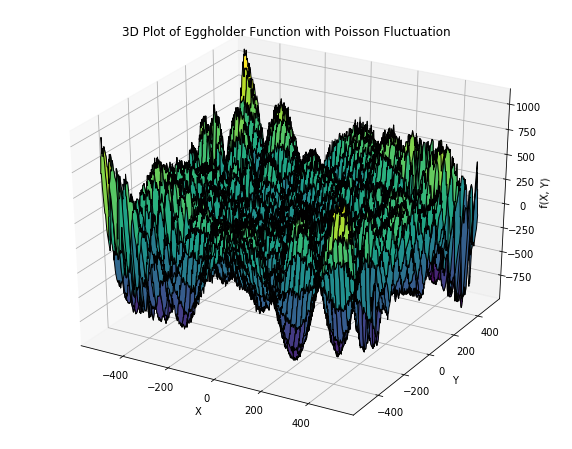

In [71]:
# Plot the scatter plot
likelihood.plot_scatter()

In [72]:
peaks, troughs = likelihood.find_peaks_troughs()

print("Number of peaks(local maxima):", peaks)
print("Number of troughs(local minima):", troughs)


Number of peaks(local maxima): 198
Number of troughs(local minima): 213


In [73]:
local_minima = likelihood.find_all_local_minima(troughs, range_x=(-512, 512), range_y=(-512, 512))

print("Total number of local minima:", len(local_minima))
print("Local minima:")
for point in local_minima:
    x, y = point
    value = likelihood.evaluate(point)
    print(f"({x}, {y}), value: {value}")

Total number of local minima: 213
Local minima:
(-391.26087935170955, -82.95464443983987), value: 16.927509389001038
(156.9708883964493, 357.61758913992156), value: -0.14561870503031038
(-98.12709631293389, 485.76517789879796), value: -0.3863294672729676
(559.1468113493773, 156.84103473675336), value: -0.9095555621873951
(121.69085026232823, -203.67838159011518), value: 44.94638075272268
(263.18966691196704, 305.0161066834102), value: 0.0025993082665727585
(-559.0913687600244, -250.78564908019405), value: 1.2936172404636934
(408.15544485006563, 5.849355694424589), value: 16.670301999924263
(-190.85231338865407, -198.37389572811017), value: -0.2888067152444497
(-190.74713367070973, -198.2687163124507), value: 0.4710818332851994
(105.26223041799678, 147.09900773587418), value: -0.003976906421783014
(25.655703186328438, 425.059198447074), value: -5.802262629869409
(348.7283272973233, 262.24990969259204), value: 0.024311765500110355
(263.1452650899567, -139.13540818144816), value: -0.12700

In [81]:
# Find local minimum from any 1 starting point using the gradient descent method
start_point = [-560, -560]  # Define the starting point 
local_min, history = likelihood.find_local_minimum(start_point)

x, y = local_min
likeli_value = likelihood.evaluate(local_min)

print("Local Minimum:", local_min, "value:", likeli_value)

print()

Local Minimum: [-559.27758349 -566.79916589] value: -1.0553491777574694e-05


In [83]:
# Find the global minimum based on the y value
global_minima = min(local_minima, key=lambda point: point[1])

x_global, y_global = global_minima
likeli_value_global = likelihood.evaluate(global_minima)

print("Global minimum:", f"({x_global}, {y_global}), value: {likeli_value_global}")

-559.2766445693899 -566.7982269650324
Global minimum: (-559.2766445693899, -566.7982269650324), value: 0.012935413575022817
